# 使用LSTM预测时序数据

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as tud
import random

## 数据
构造两维时序数据，分别是添加了满足$N\tilde (0,0.05)$噪声的正弦函数和余弦函数

In [2]:
sin = [np.sin(x * .1) + np.random.normal(0, .05, 1)[0] for x in range(0, 10000)]
cos = [np.cos(x * .1) + np.random.normal(0, .05, 1)[0] for x in range(0, 10000)]
sin, cos

([0.01346353471399279,
  0.15275657969210307,
  0.12344436560322584,
  0.29667145768269565,
  0.4065336688859127,
  0.4242822166972908,
  0.6344123608737343,
  0.7075806279951075,
  0.6329994585653036,
  0.8072954153391108,
  0.8536957239048814,
  0.7853315518234341,
  0.9552850322865654,
  0.9553576797496749,
  1.0032583794205487,
  1.1567231302956351,
  1.0727658557986157,
  1.1032287230641555,
  0.9656669588932941,
  0.9565174447195514,
  0.928882592633565,
  0.8927398830542737,
  0.7587327828913356,
  0.761146350746854,
  0.6735213074163972,
  0.6451028040922254,
  0.4867571087362147,
  0.3705046122528891,
  0.34437017650002194,
  0.230946790580811,
  0.08145473651372351,
  0.03712618362289528,
  0.0310273013810225,
  -0.13746445302236263,
  -0.18670671434143235,
  -0.33764746815371804,
  -0.3455588354055765,
  -0.433872494626917,
  -0.7371940319910741,
  -0.6443149515781458,
  -0.6728741083191507,
  -0.8881449383307073,
  -0.9601229457224603,
  -0.89612443568644,
  -0.969538146921

In [3]:
data = torch.tensor([[sin[i:i + 10], cos[i:i + 10]] for i in range(0, 10000 - 11)])
data.shape

torch.Size([9989, 2, 10])

### 构建训练集的DataLoader

In [4]:
batch_size = 64
data_loader = tud.DataLoader(data[100:], batch_size=batch_size, shuffle=True, num_workers=4)

## 建立一层的LSTM网络，只取最后一个时刻的输出
``nn.LSTM()``的参数列表：
* ``input_size``: 输入的特征维度（几维序列数据）
* ``hidden_size``: 隐藏层的维度（输出的维度）
* ``num_layers``: 隐藏层数，默认是1
* ``bias``: 默认为True
* ``batch_first``: 默认为False。若为True，则输入的数据格式是**(batch_size, seq_len, features)**。
* ``dropout``: 除最后一层，每一层的输出都进行dropout。默认为0。
* ``bidirection``: 是否为双向LSTM。默认为False。

输入：input, ($h_0$, $c_0$)

输出：output, ($h_n$, $c_n$)

输入数据格式： 
* input(seq_len, batch_size, input_size) 
* $h_0$(num_layers * num_directions, batch_size, hidden_size) 
* $c_0$(num_layers * num_directions, batch_size, hidden_size)

输出数据格式： 
* output(seq_len, batch_size, hidden_size * num_directions) 
* $h_n$(num_layers * num_directions, batch_size, hidden_size) 
* $c_n$(num_layers * num_directions, batch_size, hidden_size)

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, input_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # 输出为
        output, _ = self.lstm(x)
        pred = self.fc(self.relu(output[-1]))
        return pred
    
lstm = LSTM(2, 5)

In [6]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)

## 开始训练

In [7]:
for epoch in range(50):
    training_loss = 0
    for i, train_data in enumerate(data_loader, 0):
        X_train = train_data[:, :, :9]
        Y_train = train_data[:, :, 9:].view(X_train.shape[0], -1)
        # 使用permute将X_train的维度变为(seq_len, batch_size, features)
        X_train = X_train.permute(2, 0, 1)
        pred = lstm(X_train)
        
        optimizer.zero_grad()
        loss = loss_fn(pred, Y_train)
        loss.backward()
        optimizer.step()
        print(loss.item())

0.5426561832427979
0.4932565987110138
0.5379126071929932
0.48906344175338745
0.4300680160522461
0.5037252902984619
0.4908983111381531
0.5009587407112122
0.5001430511474609
0.4813603162765503
0.4944210648536682
0.4620998799800873
0.4510853886604309
0.4579741358757019
0.48659011721611023
0.46745598316192627
0.4687896966934204
0.45883411169052124
0.45625466108322144
0.45099911093711853
0.4546416997909546
0.4769045412540436
0.4797952473163605
0.43459826707839966
0.45178908109664917
0.4340951144695282
0.45094189047813416
0.43376708030700684
0.4625391960144043
0.40589290857315063
0.4143586754798889
0.39503780007362366
0.40822798013687134
0.4192258417606354
0.4242873191833496
0.4169413149356842
0.40006911754608154
0.39998888969421387
0.4000049829483032
0.4269053339958191
0.39928770065307617
0.39499443769454956
0.42376166582107544
0.4043503999710083
0.39428970217704773
0.3746265172958374
0.4092780649662018
0.43247660994529724
0.38719266653060913
0.3980576992034912
0.3971346914768219
0.37899270

0.009840472601354122
0.0086147366091609
0.010127320885658264
0.010293195024132729
0.008941302075982094
0.008523644879460335
0.009126614779233932
0.010390464216470718
0.01026139035820961
0.006759812589734793
0.009654930792748928
0.010584378615021706
0.010656768456101418
0.009675757959485054
0.007851431146264076
0.00837287213653326
0.009582419879734516
0.00904637761414051
0.008928129449486732
0.008722453378140926
0.009585856460034847
0.009766040369868279
0.00900202989578247
0.009259732440114021
0.009456886909902096
0.009273475967347622
0.009181840345263481
0.010235399939119816
0.008820018731057644
0.006568531040102243
0.008103687316179276
0.006494008004665375
0.008118418976664543
0.007075871806591749
0.007614458911120892
0.007841267623007298
0.010449579916894436
0.008597115986049175
0.009279526770114899
0.007804209366440773
0.007623928599059582
0.007877027615904808
0.010363428853452206
0.007223399356007576
0.007571608293801546
0.008344489149749279
0.0069905598647892475
0.0074920998886227

0.0032791891135275364
0.004101114347577095
0.00393604626879096
0.0035089245066046715
0.0032788326498121023
0.0039238594472408295
0.004213365726172924
0.003481526393443346
0.004698272794485092
0.0035915509797632694
0.0037684920243918896
0.00406614039093256
0.0037529664114117622
0.004134040325880051
0.004016561433672905
0.0033398715313524008
0.0033488483168184757
0.0041512781754136086
0.0037628659047186375
0.004143723752349615
0.003673017490655184
0.0038732083048671484
0.0038396387826651335
0.003205837681889534
0.0036712735891342163
0.003803487401455641
0.004612177610397339
0.004490998107939959
0.003042696276679635
0.0037474266719073057
0.0038820109330117702
0.0030879247933626175
0.0034338091500103474
0.003734997473657131
0.004461837932467461
0.0038821622729301453
0.0034647048451006413
0.0039127483032643795
0.0033075609244406223
0.004233893472701311
0.0032596115488559008
0.004164664074778557
0.003147742711007595
0.004092550370842218
0.004490646533668041
0.0037684862036257982
0.0041784844

0.00356403854675591
0.0036501858849078417
0.0031769080087542534
0.004583343397825956
0.003632691688835621
0.004073519259691238
0.0034358093980699778
0.003168913535773754
0.004088273271918297
0.0034683081321418285
0.0035775471478700638
0.003858662908896804
0.0031445135828107595
0.003280959092080593
0.00310899899341166
0.003611536230891943
0.002643774962052703
0.0026178930420428514
0.0034353381488472223
0.0039010485634207726
0.00369775271974504
0.00327708525583148
0.003476347541436553
0.0031759939156472683
0.0023515697102993727
0.003790950169786811
0.002999774180352688
0.002946194726973772
0.0026755318976938725
0.004282831680029631
0.003151893150061369
0.003175386693328619
0.0027619395405054092
0.0030104678589850664
0.0032131446059793234
0.004086650907993317
0.0031439163722097874
0.0031625526025891304
0.0027985088527202606
0.0031276445370167494
0.003148874267935753
0.0034951530396938324
0.0027932978700846434
0.003409285331144929
0.003424528054893017
0.0032578022219240665
0.00311324372887

0.003459477098658681
0.0027012338396161795
0.0024086441844701767
0.003600053023546934
0.003154442412778735
0.0037255031056702137
0.0030088801868259907
0.003647950477898121
0.00265639740973711
0.0024525246117264032
0.003009816398844123
0.0031521643977612257
0.0026482013054192066
0.003357407171279192
0.003140993183478713
0.0029750626999884844
0.002934571821242571
0.0024552587419748306
0.003082256531342864
0.0027805117424577475
0.0025768736377358437
0.002954306313768029
0.0030976540874689817
0.002819489222019911
0.0028644404374063015
0.003234818112105131
0.0035517667420208454
0.0032602413557469845
0.003114988561719656
0.002583869732916355
0.0029982104897499084
0.0029281028546392918
0.00248228688724339
0.003253562143072486
0.003270149463787675
0.0027362792752683163
0.0026793302968144417
0.003930069971829653
0.003357083071023226
0.0030505626928061247
0.003403360489755869
0.0035013603046536446
0.0031540393829345703
0.0031283374410122633
0.00376258441247046
0.00272032106295228
0.0032124388962

0.002332576084882021
0.0031582259107381105
0.002914787270128727
0.0026731251273304224
0.0023310286924242973
0.002453566063195467
0.003173931036144495
0.0026090359315276146
0.003101527690887451
0.003367689438164234
0.0027789254672825336
0.0030046063475310802
0.0025479570031166077
0.0033028197940438986
0.0029121313709765673
0.0034090217668563128
0.003009689738973975
0.0031572305597364902
0.002792698796838522
0.0037321599666029215
0.002654697047546506
0.0034743030555546284
0.0028672406915575266
0.002836822997778654
0.0027138041332364082
0.0030451775528490543
0.0029667955823242664
0.0030401877593249083
0.0028687533922493458
0.003286033868789673
0.0025392884854227304
0.0026790162082761526
0.0024995231069624424
0.002680639736354351
0.0031569208949804306
0.0028065242804586887
0.002784930868074298
0.0025311715435236692
0.002999346237629652
0.0032143988646566868
0.0031183594837784767
0.0028629025910049677
0.0028892834670841694
0.0034777196124196053
0.002985503524541855
0.0024067219346761703
0.0

0.0025918474420905113
0.002464686054736376
0.00298702553845942
0.002072699600830674
0.003672630526125431
0.003263677004724741
0.003241967875510454
0.0023494393099099398
0.0029506434220820665
0.00290277530439198
0.003258539829403162
0.002678781747817993
0.0030444045551121235
0.002828782657161355
0.0034079919569194317
0.002974474336951971
0.002781448420137167
0.002815776038914919
0.0030946179758757353
0.003050675615668297
0.002937900833785534
0.0027242773212492466
0.0025025522336363792
0.0035846533719450235
0.002307852730154991
0.0030744026880711317
0.0030360750388354063
0.0029088875744491816
0.0035227457992732525
0.0027256321627646685
0.0028774510137736797
0.0027867499738931656
0.0029707395005971193
0.0031887886580079794
0.0024280233774334192
0.0026377348694950342
0.0026117083616554737
0.002333493437618017
0.003095059422776103
0.0032389615662395954
0.002431641798466444
0.00344769936054945
0.003075155895203352
0.0024090767838060856
0.0031298240646719933
0.002475965302437544
0.00314425467

0.002507709665223956
0.003188020782545209
0.002837670501321554
0.0029493202455341816
0.003140619257465005
0.0028776575345546007
0.0029109339229762554
0.003184861270710826
0.002657233504578471
0.0027427400927990675
0.0023905474226921797
0.0030712224543094635
0.002668107394129038
0.0026005269028246403
0.0027598938904702663
0.002695162082090974
0.003430975368246436
0.0033948307391256094
0.0023050829768180847
0.0025571812875568867
0.002335510915145278
0.00283881276845932
0.003062721574679017
0.0017046434804797173
0.0026159207336604595
0.002723953453823924
0.0018993180710822344
0.0032646378967911005
0.0029792124405503273
0.0034271730110049248
0.003031234722584486
0.0030349481385201216
0.00324716093018651
0.0028877847362309694
0.0025970826391130686
0.0023384306114166975
0.0033453498035669327
0.0033408228773623705
0.0024524207692593336
0.0029403266962617636
0.0031028350349515676
0.0032609845511615276
0.0023583618458360434
0.0032879901118576527
0.002669154666364193
0.0027641644701361656
0.0030

0.0026372303254902363
0.002603348344564438
0.0025404023472219706
0.0036480168346315622
0.002887860406190157
0.002805995987728238
0.00267444783821702
0.0029388482216745615
0.0029126498848199844
0.002505335956811905
0.0029511270113289356
0.003059529000893235
0.0025856615975499153
0.0026785258669406176
0.002819154877215624
0.0035408814437687397
0.002322274725884199
0.0024119915906339884
0.00241849385201931
0.003054993925616145
0.00282968464307487
0.0037021911703050137
0.002730468986555934
0.002768564270809293
0.002844915259629488
0.0034255795180797577
0.002091112779453397
0.002850460121408105
0.0025736894458532333
0.002092145150527358
0.002425991464406252
0.0025562657974660397
0.002477868227288127
0.0024742677342146635
0.002635600045323372
0.002892156597226858
0.003071737475693226
0.003030315274372697
0.0031365402974188328
0.0035653230734169483
0.0030499002896249294
0.0030990452505648136
0.00231928750872612
0.002966245636343956
0.0034853355027735233
0.002751426538452506
0.0027804865967482

0.002444697543978691
0.002690924098715186
0.0031030974350869656
0.002588576404377818
0.002775588072836399
0.002830356126651168
0.003594544716179371
0.0027766157872974873
0.002888713264837861
0.0025043629575520754
0.0021420728880912066
0.003299167612567544
0.002713172696530819
0.002882080152630806
0.0025864182971417904
0.002924335189163685
0.0027657749596983194
0.003289471846073866
0.0026689583901315928
0.0027697617188096046
0.0025090540293604136
0.0030913054943084717
0.0031649344600737095
0.0029744545463472605
0.003190018469467759
0.0027818684466183186
0.002689315937459469
0.003088702680543065
0.002935037948191166
0.0023816304747015238
0.0036342134699225426
0.003201588522642851
0.003342387732118368
0.002642605919390917
0.0028970655985176563
0.002682010643184185
0.002751000691205263
0.0029593934305012226
0.003005628241226077
0.00252806069329381
0.002542857313528657
0.0031451801769435406
0.0027741172816604376
0.002528676763176918
0.0026760457549244165
0.0025412975810468197
0.003361087292

0.0029241545125842094
0.0027543148025870323
0.0034028294030576944
0.0028010623063892126
0.002869561081752181
0.0025315876118838787
0.0031399615108966827
0.0029551624320447445
0.00272513460367918
0.0025416407734155655
0.0026808367110788822
0.00235939328558743
0.0034478867892175913
0.0025196834467351437
0.002892813179641962
0.0026214695535600185
0.0024628660175949335
0.0027242854703217745
0.0034131528809666634
0.002379803452640772
0.0025973408482968807
0.0027947723865509033
0.003419802524149418
0.00284357788041234
0.003386449534446001
0.003228669986128807
0.002744570141658187
0.0031297393143177032
0.0020099938847124577
0.003258564043790102
0.0027305055409669876
0.0022528357803821564
0.002594348043203354
0.0028120072092860937
0.002890395699068904
0.002624198328703642
0.0026968023739755154
0.0022543577942997217
0.0033536939881742
0.002894212957471609
0.0030133824329823256
0.0029541514813899994
0.002525722375139594
0.0031209681183099747
0.002955733798444271
0.0027712301816791296
0.002276156

0.0024393501225858927
0.0028985764365643263
0.002555145649239421
0.0026370473206043243
0.0034505168441683054
0.003094020765274763
0.0030167894437909126
0.002572122495621443
0.002520326292142272
0.002825432922691107
0.0030157873407006264
0.0029892525635659695
0.0030482113361358643
0.003204839304089546
0.002613561460748315
0.0030379691161215305
0.0026778685860335827
0.0034401542507112026
0.002675304189324379
0.0024779662489891052
0.0025931536220014095
0.0030516586266458035
0.0028675554785877466
0.0025115511380136013
0.002560263266786933
0.0024685480166226625
0.0029874853789806366
0.0026538607198745012
0.002411654219031334
0.002699935110285878
0.0032954844646155834
0.0028187164571136236
0.002706950530409813
0.0032081801909953356
0.0026512034237384796
0.0026623259764164686
0.002762132789939642
0.0025823828764259815
0.0029650137294083834
0.0028171902522444725
0.0026736310683190823
0.0027146455831825733
0.0025847197975963354
0.0027531059458851814
0.0021827095188200474
0.0025821628514677286
0

0.002677152631804347
0.002470338251441717
0.0023756830487400293
0.003118297317996621
0.0028675422072410583
0.0032101385295391083
0.002654838375747204
0.0025471483822911978
0.0032292702235281467
0.0032916697673499584
0.0028436975553631783
0.0029752282425761223
0.002484050812199712
0.003321370342746377
0.002802036702632904
0.0027199224568903446
0.002940536243841052
0.002900312189012766
0.0023927129805088043
0.0031094825826585293
0.0027901511639356613
0.002796867396682501
0.002484201919287443
0.0032188158947974443
0.002484871307387948
0.0022124014794826508
0.0027537711430341005
0.0028003202751278877
0.003381246468052268
0.0028809108771383762
0.00292081362567842
0.0026994540821760893
0.0029121222905814648
0.002782936440780759
0.0033056228421628475
0.0031669726595282555
0.0026973728090524673
0.003387611359357834
0.0031703002750873566
0.0027294354513287544
0.002344416454434395
0.002756898757070303
0.003337211674079299
0.003148153191432357
0.0021756638307124376
0.0027256011962890625
0.0022955

0.003156184684485197
0.002546794945374131
0.002838264685124159
0.0024179143365472555
0.002868681913241744
0.0026436084881424904
0.002364515094086528
0.0025538273621350527
0.0026014335453510284
0.0031893104314804077
0.002271324396133423
0.0028276722878217697
0.002601535525172949
0.0033010791521519423
0.0027119817677885294
0.003170001320540905
0.003084337105974555
0.0025372912641614676
0.0030584100168198347
0.0033257773611694574
0.0033894034568220377
0.002372827846556902
0.002549224765971303
0.002353888703510165
0.0025735709350556135
0.001982716377824545
0.002282311674207449
0.002497024368494749
0.0037306202575564384
0.0028143806848675013
0.0022256565280258656
0.002199181355535984
0.002990802749991417
0.002433281857520342
0.0027632461860775948
0.002499775495380163
0.0026254006661474705
0.0028471173718571663
0.0025393995456397533
0.003050087718293071
0.002055204939097166
0.003331100568175316
0.0024060802534222603
0.0032041275408118963
0.0029027750715613365
0.002842627465724945
0.003071509

0.003118347143754363
0.0025893626734614372
0.002507920144125819
0.003198137739673257
0.00300700799562037
0.0024686618708074093
0.003218250349164009
0.003055383451282978
0.0027300964575260878
0.0024398379027843475
0.0029580285772681236
0.0025845912750810385
0.002517424523830414
0.00208268198184669
0.003410185454413295
0.00229173107072711
0.0021633226424455643
0.002705947495996952
0.0031390117947012186
0.0024027014151215553
0.0029582143761217594
0.0034024035558104515
0.002901087747886777
0.002854870166629553
0.0028136081527918577
0.002348463051021099
0.0028498806059360504
0.0029404349625110626
0.0031237155199050903
0.002617069287225604
0.002568707335740328
0.0032092079054564238
0.003200225066393614
0.0028348485939204693
0.002160529140383005
0.0026508152950555086
0.0022978491615504026
0.002803651150316
0.002670604269951582
0.00255171419121325
0.003077423432841897
0.003355950815603137
0.0029812385328114033
0.002667164197191596
0.0027822349220514297
0.0026374657172709703
0.00341250305064022

0.002851978875696659
0.002578470390290022
0.0028824470937252045
0.0021308641880750656
0.0027610540855675936
0.0029883335810154676
0.002545372350141406
0.002930666785687208
0.00279812840744853
0.0032854534219950438
0.002759739523753524
0.0028806969057768583
0.002483763499185443
0.0031402157619595528
0.003009482752531767
0.0034801559522747993
0.0033362300600856543
0.002973059192299843
0.0026080680545419455
0.0029246555641293526
0.002702810801565647
0.0022024025674909353
0.0034136809408664703
0.0031287071760743856
0.0026011550799012184
0.002810155041515827
0.003060599323362112
0.0029570104088634253
0.0024745934642851353
0.002754724118858576
0.0028387117199599743
0.0026496031787246466
0.0021212485153228045
0.0032445299439132214
0.0025625652633607388
0.002833898412063718
0.003122390480712056
0.002309398725628853
0.0025233703199774027
0.0031694690696895123
0.002834940794855356
0.0033824979327619076
0.0023373060394078493
0.0026551580522209406
0.0026650342624634504
0.003088038181886077
0.00254

0.0030319381039589643
0.002499793190509081
0.002888600341975689
0.0027897804975509644
0.0026185279712080956
0.0032814648002386093
0.0024545774795114994
0.0025965324603021145
0.003011169843375683
0.002517599845305085
0.002714658621698618
0.0025322160217911005
0.002718115458264947
0.002630453323945403
0.0035003949888050556
0.0024912438821047544
0.002579264808446169
0.0026023215614259243
0.0027444963343441486
0.0029809833504259586
0.003285032697021961
0.002802776638418436
0.002840822096914053
0.0030179820023477077
0.002584483940154314
0.002991365734487772
0.002870832569897175
0.003174449549987912
0.0023879732470959425
0.002323680091649294
0.002398586831986904
0.002132437191903591
0.0023506474681198597
0.0027174167335033417
0.002672856440767646
0.0028982083313167095
0.002951771253719926
0.002699791919440031
0.0029154736548662186
0.0028575584292411804
0.0034338939003646374
0.003014093264937401
0.002612672746181488
0.0026276279240846634
0.003247885499149561
0.002976770279929042
0.00239198515

0.002883282722905278
0.0029503810219466686
0.0028827458154410124
0.002872082171961665
0.003082989016547799
0.0032459301874041557
0.0031514442525804043
0.002586517482995987
0.0027695964090526104
0.0028197825886309147
0.0023694848641753197
0.0024131068494170904
0.0024847746826708317
0.002186879515647888
0.0032474996987730265
0.002951083704829216
0.002180233597755432
0.002641403116285801
0.003113384125754237
0.0032285067718476057
0.0035840102937072515
0.0029956838116049767
0.0032605959568172693
0.0026089234743267298
0.0029613731894642115
0.0034527136012911797
0.0023173759691417217
0.003064432181417942
0.0025135474279522896
0.002569381846114993
0.0027106930501759052
0.003341714618727565
0.0022278723772615194
0.0023075006902217865
0.0024849707260727882
0.002491033636033535
0.0024125506170094013
0.0023797848261892796
0.0035713971592485905
0.0026865690015256405
0.0024466696195304394
0.0033833952620625496
0.002774737076833844
0.002925423439592123
0.0033587890211492777
0.0031463508494198322
0.0

0.002807581564411521
0.002840499160811305
0.0023694494739174843
0.003387422300875187
0.002399484161287546
0.003177424194291234
0.0028911943081766367
0.00206905510276556
0.0026968924794346094
0.0025516264140605927
0.003369944868609309
0.0028296802192926407
0.0035068970173597336
0.00259780022315681
0.0030273678712546825
0.002926425077021122
0.0026885070838034153
0.002044583670794964
0.003301947843283415
0.002190809929743409
0.0025744775775820017
0.00230930233374238
0.0026765461079776287
0.00268744770437479
0.0024118986912071705
0.002970546018332243
0.002699436154216528
0.0023447994608432055
0.002914078300818801
0.002575273858383298
0.0028603216633200645
0.002461767755448818
0.003061962081119418
0.002831204328685999
0.0021606378722935915
0.002714030211791396
0.003279948839917779
0.002778900321573019
0.0034063609782606363
0.0027974932454526424
0.002419695258140564
0.002846995834261179
0.0030066720210015774
0.0023070117458701134
0.002844731556251645
0.002487305086106062
0.002729445230215788

## 生成测试数据并开始测试

In [8]:
test_data = data[:100]
test_data.shape

torch.Size([100, 2, 10])

In [9]:
X_test = test_data[:, :, :9].permute(2, 0, 1)
Y_test = test_data[:, :, 9:].view(X_test.shape[1], -1)
X_test.shape, Y_test.shape

(torch.Size([9, 100, 2]), torch.Size([100, 2]))

In [10]:
y_pred = lstm(X_test)
y_pred.shape

torch.Size([100, 2])

### 展示两个维度的预测结果

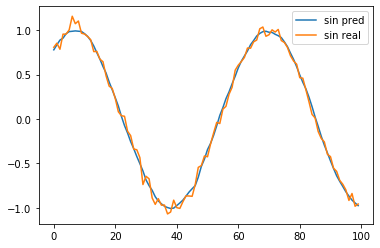

In [11]:
plt.plot(y_pred[:, 0].detach().numpy(), label='sin pred')
plt.plot(Y_test[:, 0], label='sin real')
plt.legend(loc='best')
plt.show()

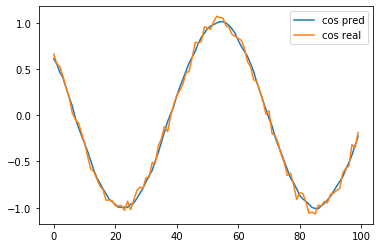

In [12]:
plt.plot(y_pred[:, 1].detach().numpy(), label='cos pred')
plt.plot(Y_test[:, 1], label='cos real')
plt.legend(loc='best')
plt.show()